In [2]:
from pathlib import Path
from collections import Counter
from random import Random


import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence


from bpemb import BPEmb
from dataset.twtita import TWITADS
from model.lstm import LSTMTagger
from model import train_model

import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

N_TOKENS, BATCH_SIZE = 1000, 128

In [3]:

def collate_fn(batch):
    tokens, tags = zip(*batch)
    return pad_sequence(tokens,batch_first=True), pad_sequence(tags, padding_value=-100,batch_first=True)

bpe = BPEmb(lang='it',vs=N_TOKENS)
word_tokenizer = lambda word: bpe.encode_ids_with_bos_eos(word)
transformer = lambda tkns,tags:  (torch.tensor(tkns), torch.tensor(tags).long())

ds_train = TWITADS('train',word_tokenizer, transform=transformer)
ds_test  = TWITADS('test',word_tokenizer, transform=transformer)
dl_train = DataLoader(ds_train, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn)
dl_test  = DataLoader(ds_test, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn)


In [4]:

tags = []
for tweet in ds_train.tweets:
    tags.extend([tag for _,tag in tweet])
c = Counter(tags)
most_common = c.most_common(1)[0][0]
baseline = (np.array(tags) == np.array([most_common]*len(tags))).mean()*100
r = Random(42)
random_m = (np.array(tags) == np.array([r.sample(c.keys(),1)[0] for _ in range(len(tags))])).mean()*100
baseline, random_m

(14.24756669305105, 4.373428896987831)

In [5]:
df = pd.read_csv("trained/lstm_grid.csv")
df.head()

,key,is_bi,lstm_layers,lstm_hidden_dim,out_layers,special_tokens,tag_mode,loss,accuracy,f1,explained_variance,alpha
0,bi_1_128_1_#ow_all,True,1,128,1,#ow,all,3.445611,0.450020,0.277744,-0.219388,35.922259
1,bi_1_128_1_#ow_first,True,1,128,1,#ow,first,1.419023,0.565245,0.480500,0.039389,20.651640
2,bi_1_128_1_#ow_last,True,1,128,1,#ow,last,1.453890,0.560622,0.474402,-0.036562,21.345548
3,bi_1_128_1_#ow_terminal,True,1,128,1,#ow,terminal,2.497622,0.432549,0.330198,-0.200632,29.263766
4,bi_1_128_1_bow_all,True,1,128,1,bow,all,3.215927,0.454667,0.282452,-0.236690,34.588675


In [6]:
columns = ['loss','accuracy','f1','explained_variance','alpha']
df[[c+"_norm" for c in columns]] = (df[columns]-df[columns].min())/(df[columns].max()-df[columns].min())
df['combined'] = 1
for c in columns:
    if c=='loss':
        pass#df['combined'] *= 1-df[c+'_norm']
    else:
        df['combined'] *= df[c+'_norm']
df.head()

,key,is_bi,lstm_layers,lstm_hidden_dim,out_layers,special_tokens,tag_mode,loss,accuracy,f1,explained_variance,alpha,loss_norm,accuracy_norm,f1_norm,explained_variance_norm,alpha_norm,combined
0,bi_1_128_1_#ow_all,True,1,128,1,#ow,all,3.445611,0.450020,0.277744,-0.219388,35.922259,0.881646,0.642625,0.461000,0.648994,0.612005,0.117667
1,bi_1_128_1_#ow_first,True,1,128,1,#ow,first,1.419023,0.565245,0.480500,0.039389,20.651640,0.031283,0.897674,0.906593,0.887456,0.269603,0.194716
2,bi_1_128_1_#ow_last,True,1,128,1,#ow,last,1.453890,0.560622,0.474402,-0.036562,21.345548,0.045913,0.887442,0.893192,0.817467,0.285162,0.184776
3,bi_1_128_1_#ow_terminal,True,1,128,1,#ow,terminal,2.497622,0.432549,0.330198,-0.200632,29.263766,0.483867,0.603954,0.576278,0.666277,0.462706,0.107299
4,bi_1_128_1_bow_all,True,1,128,1,bow,all,3.215927,0.454667,0.282452,-0.236690,34.588675,0.785270,0.652911,0.471347,0.633050,0.582103,0.113405


In [22]:
top_3_by = {}
df_ = df[df.tag_mode=="all"]
top_3_by['alpha'] = df_.sort_values('alpha_norm',ascending=False).head(3).key
top_3_by['f1'] = df_.sort_values('f1_norm',ascending=False).head(3).key
top_3_by['accuracy'] = df_.sort_values('accuracy_norm',ascending=False).head(3).key
top_3_by['explained'] = df_.sort_values('explained_variance_norm',ascending=False).head(3).key
#top_3_by['loss'] = df.sort_values('loss_norm',ascending=True).head(3).key
top_3_by['combined'] = df_.sort_values('combined',ascending=False).head(3).key
top_3_by

{'alpha': 216     mono_2_16_1_eow_all
 96        bi_2_32_1_#ow_all
 200    mono_2_128_1_eow_all
 Name: key, dtype: object,
 'f1': 136    mono_1_128_1_eow_all
 96        bi_2_32_1_#ow_all
 168     mono_1_32_1_eow_all
 Name: key, dtype: object,
 'accuracy': 188        mono_1_64_1__all
 172        mono_1_32_1__all
 136    mono_1_128_1_eow_all
 Name: key, dtype: object,
 'explained': 236       mono_2_32_1__all
 92          bi_2_16_1__all
 184    mono_1_64_1_eow_all
 Name: key, dtype: object,
 'combined': 136    mono_1_128_1_eow_all
 96        bi_2_32_1_#ow_all
 184     mono_1_64_1_eow_all
 Name: key, dtype: object}

In [23]:
unique_top_3 = set()
for v in top_3_by.values():
    for k in v:
        unique_top_3.add(k)
unique_top_3, len(unique_top_3), len(top_3_by)*3

({'bi_2_16_1__all',
  'bi_2_32_1_#ow_all',
  'mono_1_128_1_eow_all',
  'mono_1_32_1__all',
  'mono_1_32_1_eow_all',
  'mono_1_64_1__all',
  'mono_1_64_1_eow_all',
  'mono_2_128_1_eow_all',
  'mono_2_16_1_eow_all',
  'mono_2_32_1__all'},
 10,
 15)

In [24]:
unique_top_1 = set()
for k,v in top_3_by.items():
    for el in v:
        unique_top_1.add((k,el))
        break
unique_top_1, len(unique_top_1), len(top_3_by)

({('accuracy', 'mono_1_64_1__all'),
  ('alpha', 'mono_2_16_1_eow_all'),
  ('combined', 'mono_1_128_1_eow_all'),
  ('explained', 'mono_2_32_1__all'),
  ('f1', 'mono_1_128_1_eow_all')},
 5,
 5)

In [14]:
bot_3_by = {}
df_ = df#[df.tag_mode=="all"]
bot_3_by['alpha'] = df_.sort_values('alpha_norm',ascending=True).head(3).key
bot_3_by['f1'] = df_.sort_values('f1_norm',ascending=True).head(3).key
bot_3_by['accuracy'] = df_.sort_values('accuracy_norm',ascending=True).head(3).key
bot_3_by['explained'] = df_.sort_values('explained_variance_norm',ascending=True).head(3).key
#top_3_by['loss'] = df.sort_values('loss_norm',ascending=True).head(3).key
bot_3_by['combined'] = df_.sort_values('combined',ascending=True).head(3).key


In [10]:
unique_bot_3 = set()
for v in bot_3_by.values():
    for k in v:
        unique_bot_3.add(k)
unique_bot_3, len(unique_bot_3), len(bot_3_by)*3

({'bi_1_32_1__all',
  'bi_2_128_1__all',
  'mono_1_16_1__all',
  'mono_1_16_1_bow_all',
  'mono_2_128_1_bow_all',
  'mono_2_16_1_#ow_all',
  'mono_2_16_1__all',
  'mono_2_16_1_bow_all',
  'mono_2_32_1_bow_all'},
 9,
 15)

## Verify the alpha metric

Let's re-train each of these for 200 epoch, if it is a valid metric:

- bots should not improve significatly after the 100th epoch
- tops should keep improving 

In [32]:


def collate_fn(batch):
    tokens, tags = zip(*batch)
    return pad_sequence(tokens, batch_first=True), pad_sequence(tags, padding_value=-100, batch_first=True)


bpe = BPEmb(lang='it', vs=N_TOKENS)


def mk_dl(special, tag_mode, ds_names=['train', 'test']):
    if special == '#ow':
        def word_tokenizer(word): return [1, *bpe.encode_ids(word), 2]
    elif special == 'eow':
        def word_tokenizer(word): return [*bpe.encode_ids(word), 2]
    if special == 'bow':
        def word_tokenizer(word): return [1, *bpe.encode_ids(word)]
    elif special == '':
        def word_tokenizer(word): return bpe.encode_ids(word)

    def transformer(tkns, tags): return (
        torch.tensor(tkns), torch.tensor(tags).long())

    ds_train = TWITADS(ds_names[0], word_tokenizer,
                       transform=transformer, tag_mode=tag_mode)
    ds_test = TWITADS(ds_names[1], word_tokenizer,
                      transform=transformer, tag_mode=tag_mode)
    return (
        ds_train.n_tags,
        DataLoader(ds_train, shuffle=True,
                   batch_size=BATCH_SIZE, collate_fn=collate_fn),
        DataLoader(ds_test, shuffle=True,
                   batch_size=BATCH_SIZE, collate_fn=collate_fn)
    )


def mk_from_key(key, ds_names=['train', 'test']):
    is_bi, l_layers, hid_dim, o_layers, special_tkns, tg_mode = key.split('_')

    is_bi, l_layers, hid_dim, o_layers = is_bi == 'bi', int(
        l_layers), int(hid_dim), int(o_layers)
    n_tags, dl_tr, dl_te = mk_dl(special_tkns, tg_mode, ds_names)
    m = LSTMTagger(
        N_TOKENS,
        n_tags,
        hidden_dim=hid_dim,
        dropout=0.1,
        lstm_layers=l_layers,
        bidirectional=is_bi,
        output_layers=o_layers
    )

    return m, dl_tr, dl_te

def do_train(key):
    model, dl_tr, dl_val = mk_from_key(k,['resampled_train','resampled_validation'])
    loss, acc = train_model(model,dl_tr,dl_val,cuda=True,lr=0.1,epochs=200,show_plots=False)
    return model, loss, acc

In [33]:
goods,bads = list(top_3_by['alpha']), list(bot_3_by['alpha'])

mono_1_32_1_#ow_first


100%|██████████| 200/200 [13:17<00:00,  3.99s/it]


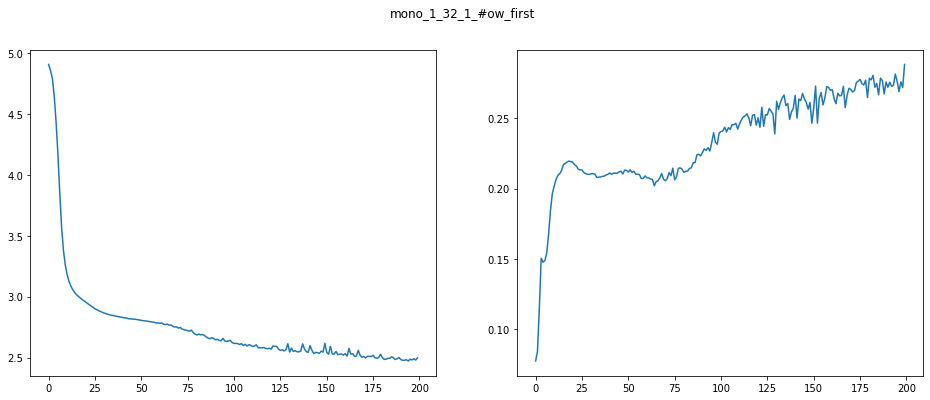

In [34]:
k = bads[0]
print(k)
m, los, acc = do_train(k)
plt.figure(figsize=(16,6))
plt.suptitle(k)
plt.subplot(121)
plt.plot(los)
plt.subplot(122)
plt.plot(acc)

bi_2_128_1__last


100%|██████████| 200/200 [1:08:54<00:00, 20.67s/it] 


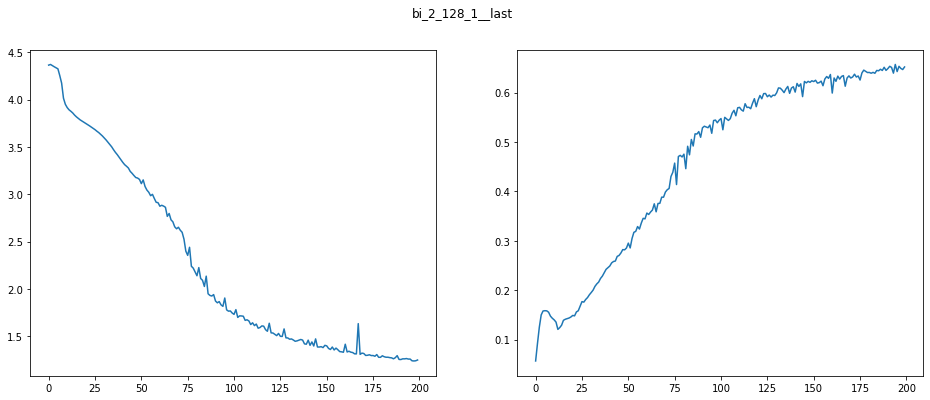

In [35]:
k = goods[0]
print(k)
m, los, acc = do_train(k)
plt.figure(figsize=(16,6))
plt.suptitle(k)
plt.subplot(121)
plt.plot(los)
plt.subplot(122)
plt.plot(acc)

it's clear that the improvement between the the 100th epoch and last exist in both cases, not significative for early convgence relevation

## Notes

- bi_2_128_1_#ow_terminal is taking a lot more than bi_2_128_1__terminal Why?

    encode_ids_with_bos_eos -> take more time?

    just prepend and post pend token "manually" BOS==1 EOS==2

        -> it pass from ~30m to ~27m not very meaningful
        
        --> so probably the 'problem' is the longer sentece, nothing to do